In [2]:
from datetime import date
import numpy as np
import mne as mne
import matplotlib.pyplot as plt


ELECTRODES_NUM = 35

today = date.today().strftime("%b-%d-%Y")
month = date.today().strftime("%B")
root_folder = f"data/{month}/{today}"
matlab_data_folder = "data/igor"

In [3]:
# Fetch the data from the .set file
epochs_right = mne.io.read_epochs_eeglab(matlab_data_folder + '/s1_selected.set')
epochs_left = mne.io.read_epochs_eeglab(matlab_data_folder + '/s2_selected.set')
epochs_no_move = mne.io.read_epochs_eeglab(matlab_data_folder + '/s4_selected.set')

epochs_right = mne.epochs.combine_event_ids(epochs_right,['S  1'], {'Right': 5}, True)
epochs_left = mne.epochs.combine_event_ids(epochs_left,['S  2'], {'Left': 6}, True)
epochs_no_move = mne.epochs.combine_event_ids(epochs_no_move,['S  4', 'S 12/S  4'], {'NoMove': 7}, True)

epochs_right = mne.epochs.combine_event_ids(epochs_right,['Right'], {'Right': 2}, True)
epochs_left = mne.epochs.combine_event_ids(epochs_left,['Left'], {'Left': 3}, True)
epochs_no_move = mne.epochs.combine_event_ids(epochs_no_move,['NoMove'], {'NoMove': 1}, True)

epochs = mne.concatenate_epochs([epochs_right, epochs_left, epochs_no_move])

epochs.crop(tmin=0.1, tmax=0.798)

Extracting parameters from c:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\eeg-bss\data\igor\s1_selected.set...
Not setting metadata
3445 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from c:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\eeg-bss\data\igor\s2_selected.set...
Not setting metadata
3252 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from c:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\eeg-bss\data\igor\s4_selected.set...


C:\Users\alonb\AppData\Local\Temp\ipykernel_2852\44228689.py:4: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs_no_move = mne.io.read_epochs_eeglab(matlab_data_folder + '/s4_selected.set')


Not setting metadata
3166 matching events found
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
9863 matching events found
No baseline correction applied
0 bad epochs dropped


Number of events,9863
Events,Left: 3252NoMove: 3166Right: 3445
Time range,0.100 – 0.798 sec
Baseline,off


In [4]:
# Create the train set and test set
total_num_of_epochs = len(epochs)

train_set_indexes = []
test_set_indexes = []
for i in range(total_num_of_epochs):
    random_num = np.random.rand()
    if (random_num < 0.8):  # 80% chance of being here
        train_set_indexes.append(i)
    else:
        test_set_indexes.append(i)

train_set = epochs[train_set_indexes]
test_set = epochs[test_set_indexes]

print(f"Total number of Epochs: {total_num_of_epochs}")
print(f"Train set size: {len(train_set)} ({len(train_set) / total_num_of_epochs}). Left: {len(train_set['Left'].selection)} ({len(train_set['Left'].selection) / len(train_set)}), Right: {len(train_set['Right'].selection)} ({len(train_set['Right'].selection) / len(train_set)}), No Move: {len(train_set['NoMove'].selection)} ({len(train_set['NoMove'].selection) / len(train_set)})")
print(f"Train set size: {len(test_set)} ({len(test_set) / total_num_of_epochs}). Left: {len(test_set['Left'].selection)} ({len(test_set['Left'].selection) / len(test_set)}), Right: {len(test_set['Right'].selection)} ({len(test_set['Right'].selection) / len(test_set)}), No Move: {len(test_set['NoMove'].selection)} ({len(test_set['NoMove'].selection) / len(test_set)})")

Total number of Epochs: 9863
Train set size: 7910 (0.8019872249822569). Left: 2598 (0.3284450063211125), Right: 2750 (0.347661188369153), No Move: 2562 (0.3238938053097345)
Train set size: 1953 (0.1980127750177431). Left: 654 (0.3348694316436252), Right: 695 (0.35586277521761395), No Move: 604 (0.3092677931387609)


In [5]:
# Fit ICA
ica = mne.preprocessing.ICA(n_components = ELECTRODES_NUM, method='picard')
ica.fit(train_set)
ica.save(root_folder + '/igor-ica.fif', overwrite=True)

Fitting ICA to data using 35 channels (please be patient, this may take a while)


C:\Users\alonb\AppData\Local\Temp\ipykernel_2852\2786637139.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(train_set)


Selecting by number: 35 components
Fitting ICA took 395.7s.
Writing ICA solution to c:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\eeg-bss\data\December\Dec-18-2022\igor-ica.fif...


Method,picard
Fit,88 iterations on epochs (2768500 samples)
ICA components,35
Explained variance,100.0 %
Available PCA components,35
Channel types,eeg
ICA components marked for exclusion,—


In [6]:
# Export the data
mne.export.export_epochs(root_folder + '/igor-train_set.set', train_set, overwrite=True)
mne.export.export_epochs(root_folder + '/igor-test_set.set', test_set, overwrite=True)

In [ ]:
# # Import the data
train_set = mne.io.read_epochs_eeglab(root_folder + '/igor-train_set.set')
test_set = mne.io.read_epochs_eeglab(root_folder + '/igor-test_set.set')
ica = mne.preprocessing.read_ica(root_folder + '/igor-ica.fif')

In [7]:
train_ICs = ica.get_sources(train_set)
test_ICs = ica.get_sources(test_set)

train_data = np.swapaxes(train_ICs.copy().get_data(), 0, 1)
test_data = np.swapaxes(test_ICs.copy().get_data(), 0, 1)

train_labels = train_ICs.events[:,2]
test_labels = test_ICs.events[:,2]

The average accuracy is 0.362.
The average F1 score is 0.32.


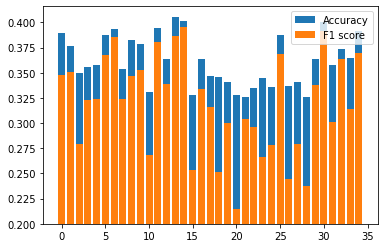

In [8]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score


f1_scores = []
accuracy_scores = []
predictions = []
for i in range(ELECTRODES_NUM):
    clf = GaussianNB()
    predictions.append(cross_val_predict(clf, train_data[i], train_labels))
    f1_scores.append(cross_val_score(clf, train_data[i], train_labels, scoring='f1_macro').mean())
    accuracy_scores.append(cross_val_score(clf, train_data[i], train_labels).mean())
    
f1_scores = np.array(f1_scores)
accuracy_scores = np.array(accuracy_scores)
print(f"The average accuracy is {round(accuracy_scores.mean(),3)}.")
print(f"The average F1 score is {round(f1_scores.mean(),3)}.")

bottom = 0.2
x = np.arange(ELECTRODES_NUM)
plt.bar(x, accuracy_scores-bottom, bottom=bottom, label="Accuracy")
plt.bar(x, f1_scores-bottom, bottom=bottom, label="F1 score")
plt.legend();

In [13]:
acc_thresh = 0.39
f1_thresh = 0.37
chosen_idxs_by_acc = np.where(accuracy_scores > acc_thresh)
chosen_idxs_by_f1 = np.where(f1_scores > f1_thresh)
chosen_idxs = tuple(np.intersect1d(chosen_idxs_by_acc, chosen_idxs_by_f1))
print(chosen_idxs)

reconstructed_from_best_train_ICs = ica.apply(train_set.copy(), include=chosen_idxs)
reconstructed_from_best_test_ICs = ica.apply(test_set.copy(), include=chosen_idxs)
mne.export.export_epochs(root_folder + '/igor-reconstructed_from_best_train_ICs.set', reconstructed_from_best_train_ICs, overwrite=True)
mne.export.export_epochs(root_folder + '/igor-reconstructed_from_best_test_ICs.set', reconstructed_from_best_test_ICs, overwrite=True)

(6, 11, 13, 14, 30, 34)
Applying ICA to Epochs instance
    Transforming to ICA space (35 components)
    Zeroing out 29 ICA components
    Projecting back using 35 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (35 components)
    Zeroing out 29 ICA components
    Projecting back using 35 PCA components
Overwriting existing file.
Overwriting existing file.


The average accuracy is 0.368.
The average F1 score is 0.334.


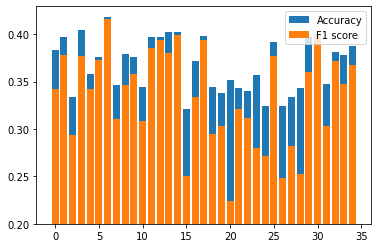

In [14]:
from sklearn.metrics import accuracy_score, f1_score

eval_f1_scores = []
eval_accuracy_scores = []
for i in range(ELECTRODES_NUM):
    clf = GaussianNB()
    clf.fit(train_data[i], train_labels)
    prediction = clf.predict(test_data[i])
    eval_accuracy_scores.append(accuracy_score(test_labels, prediction))
    eval_f1_scores.append(f1_score(test_labels, prediction, average='macro'))

eval_f1_scores = np.array(eval_f1_scores) 
eval_accuracy_scores = np.array(eval_accuracy_scores) 
print(f"The average accuracy is {round(eval_accuracy_scores.mean(),3)}.")
print(f"The average F1 score is {round(eval_f1_scores.mean(),3)}.")
bottom = 0.2
x = np.arange(ELECTRODES_NUM)
plt.bar(x, eval_accuracy_scores-bottom, bottom=bottom, label="Accuracy")
plt.bar(x, eval_f1_scores-bottom, bottom=bottom, label="F1 score")
plt.legend();

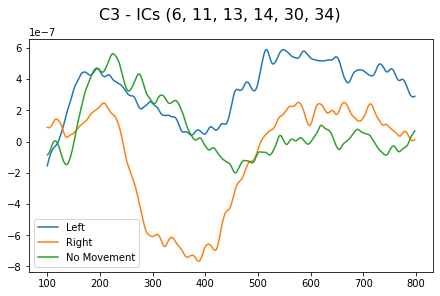

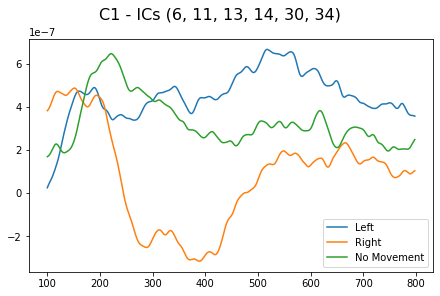

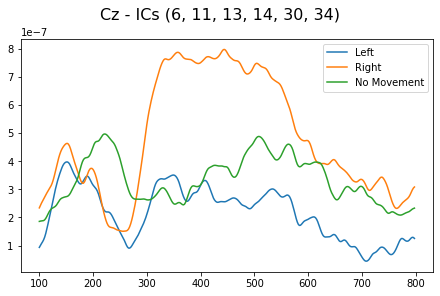

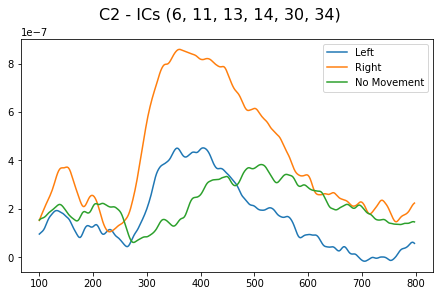

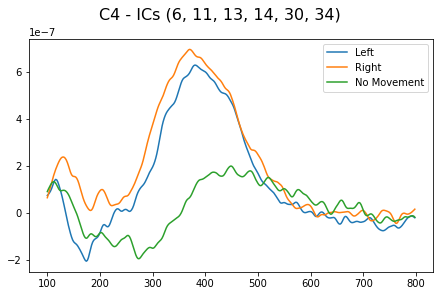

In [15]:
time_axis = reconstructed_from_best_train_ICs.times * 1000
channel_names = [['C3'], ['C1'], ['Cz'], ['C2'], ['C4']]
# channel_name = ['C3']
for channel_name in channel_names:
    fig, ax = plt.subplots(nrows = 1, ncols = 1, constrained_layout = True)
    fig.suptitle(f"{channel_name[0]} - ICs {chosen_idxs}", fontsize = 16)
    ax.plot(time_axis, np.squeeze(reconstructed_from_best_train_ICs["Left"].average().pick_channels(channel_name).get_data()), label='Left')
    ax.plot(time_axis, np.squeeze(reconstructed_from_best_train_ICs["Right"].average().pick_channels(channel_name).get_data()), label='Right')
    ax.plot(time_axis, np.squeeze(reconstructed_from_best_train_ICs["NoMove"].average().pick_channels(channel_name).get_data()), label='No Movement')
    ax.legend()